Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta
from itertools import combinations

# Modelling imports
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns_general_width   = 16
sns_general_height  = 8
sns.set(rc={'figure.figsize':(sns_general_width, sns_general_height)})
POPULATION_THRESHOLD = 1000000

## ETL

Utilities

In [3]:
# Special codes with the exception of Kosovo (OWID_KOS)
special_owid_codes = ('OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM',
       'OWID_CYN', 'OWID_OCE', 'OWID_SAM', 'OWID_UMC', 'OWID_WRL')

In [4]:
def plot_full(countries, df, title, metric, date="date"):
    for country in countries:
        _df = df[df['country'] == country]
        plt.plot(_df[date], _df[metric])
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

def plot_summary(df, title, metric, date='date', remove_mean=False):
    if not remove_mean:
        df = df.groupby(date).agg(
                mean=(metric,"mean"), 
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    else:
        df = df.groupby(date).agg(
                median=(metric,"median"),
                percentile_5=(metric, lambda x: np.nanpercentile(x, 5)),
                percentile_95=(metric, lambda x: np.nanpercentile(x, 95))
            ).reset_index()
    df.plot(df.columns[0], df.columns[1:]) # date vs mean, median, 5th, 95th
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Time')

### Stringency

In [5]:
stringency_df = pd.read_csv('data/stringency/covid-stringency-index.csv')
stringency_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)

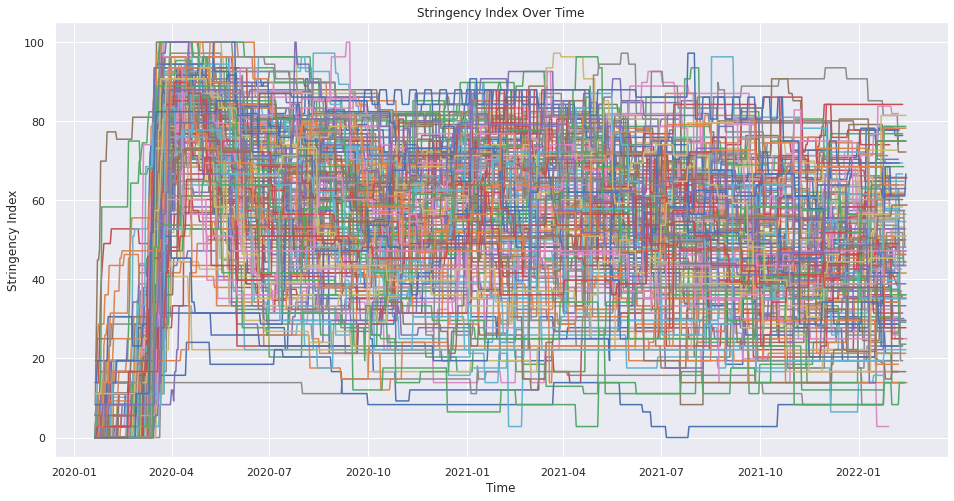

In [6]:
countries = stringency_df['country'].unique()
stringency_df['date'] = pd.to_datetime(stringency_df['date'])
plot_full(countries, stringency_df, title='Stringency Index Over Time', metric='stringency_index')

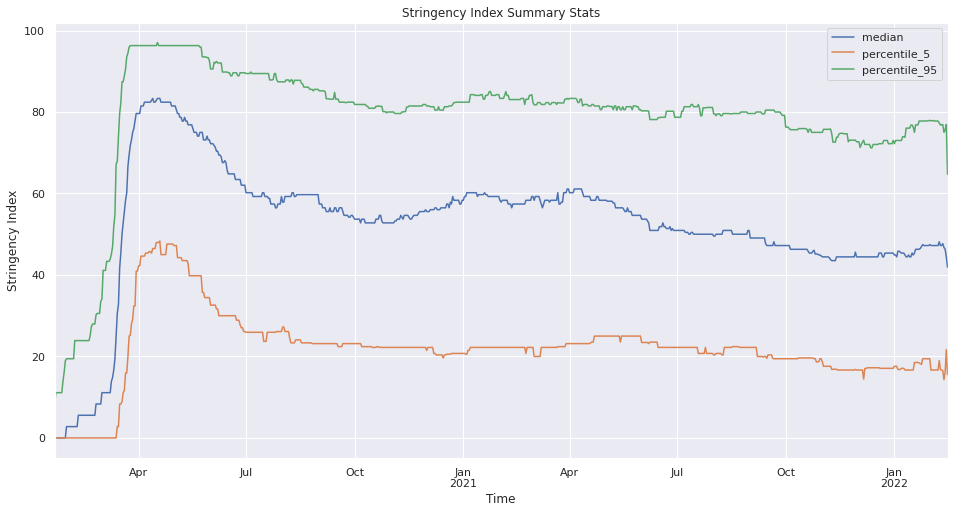

In [7]:
plot_summary(stringency_df, title='Stringency Index Summary Stats', metric='stringency_index', remove_mean=True)

---

### Containment/Health

In [8]:
containment_health_df = pd.read_csv('data/stringency/covid-containment-and-health-index.csv')
containment_health_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)

In [9]:
containment_health_df['date'] = pd.to_datetime(containment_health_df['date'])

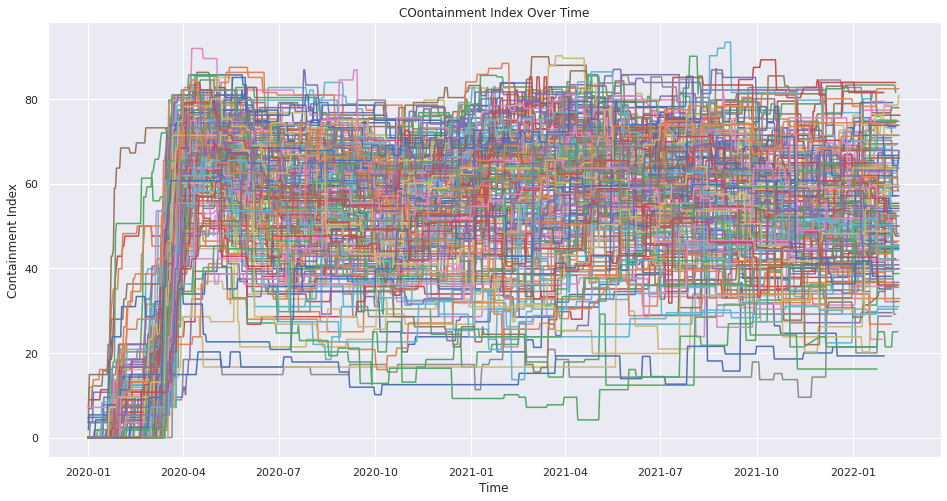

In [10]:
plot_full(countries, containment_health_df, title='COontainment Index Over Time', metric='containment_index')

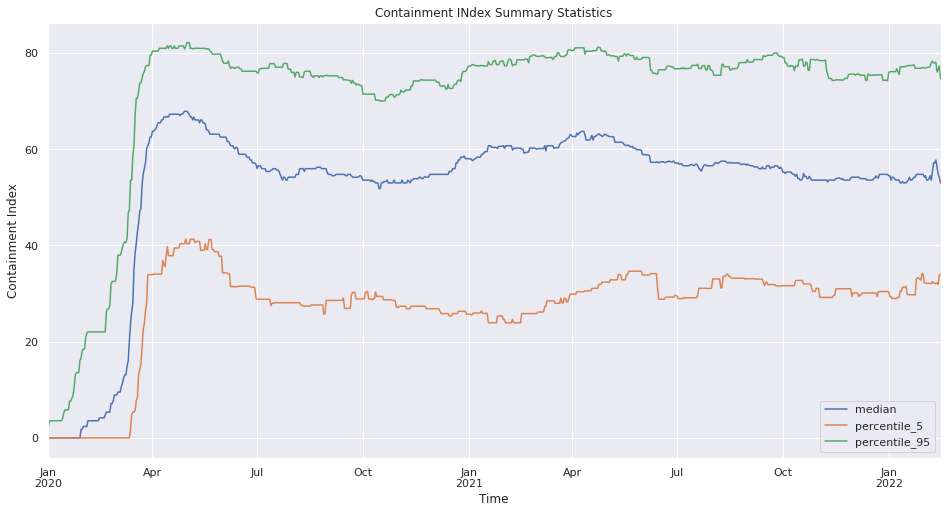

In [11]:
plot_summary(containment_health_df, title='Containment INdex Summary Statistics', metric='containment_index', remove_mean=True)

### Deaths
Deaths can be an intensity metric

In [12]:
covid_history_df = pd.read_csv('data/general/owid-covid-data.csv')
covid_history_df.rename(columns={
    "location":"country",
    "iso_code":"code"},
    inplace=True)

owid_aggregations_df = covid_history_df[covid_history_df['code'].isin(special_owid_codes)]
owid_aggregations_df.rename(columns={
    "country":"category"},
    inplace=True)

covid_history_df = covid_history_df[~covid_history_df['code'].isin(special_owid_codes)].sort_values(by=['code', 'date'])

In [13]:
income_levels = [level for level in owid_aggregations_df["category"].unique() if level.endswith("income")]
income_levels

['High income', 'Low income', 'Lower middle income', 'Upper middle income']

In [14]:
# remove rows for any country before it makes a contribution to the data
def remove_rows_before_contributions():
    for code in covid_history_df.code.unique():
        _df = covid_history_df[covid_history_df['code'] == code]
        for row in _df.itertuples():
            if (row.new_cases == 0 or row.new_cases is None) and (row.total_cases == 0 or row.total_cases is None):
                covid_history_df.drop(index=row.Index, inplace=True)
                break
        continue
remove_rows_before_contributions()

Deaths per million

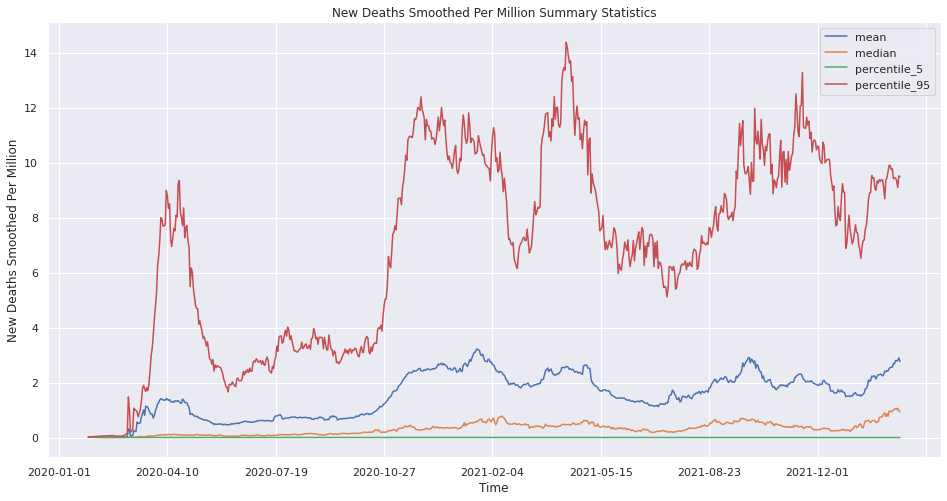

In [15]:
plot_summary(covid_history_df, title='New Deaths Smoothed Per Million Summary Statistics', metric="new_deaths_smoothed_per_million")

Mortality

In [16]:
# Align the zeros of the two y-axes
# Adapted from: https://stackoverflow.com/a/54355867/6712832
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

(0.0, 75.0)

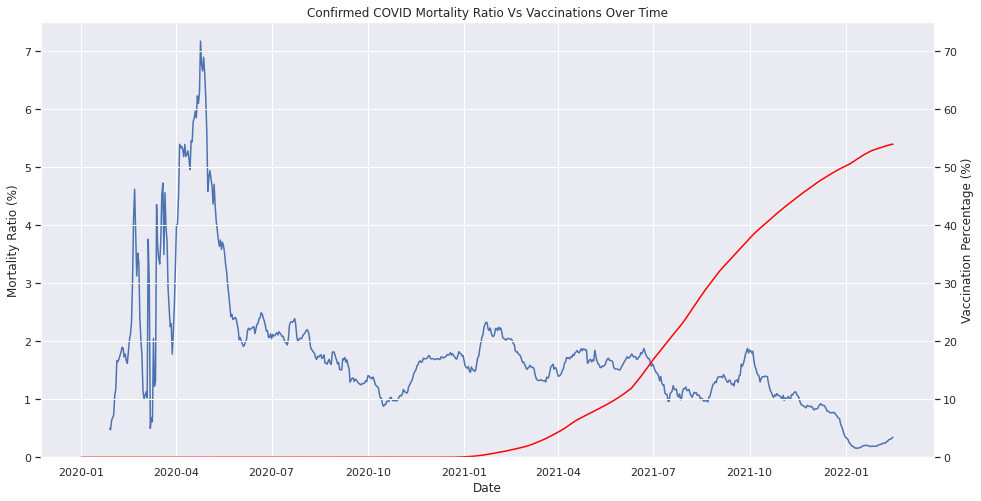

In [17]:
mortality_df = covid_history_df.groupby('date').agg('sum').reset_index()
mortality_df['date'] = pd.to_datetime(mortality_df['date'])
fig, ax = plt.subplots()

ax.plot(mortality_df['date'], 100*mortality_df['new_deaths_smoothed_per_million']/mortality_df['new_cases_smoothed_per_million'], label='Mortality Ratio')
ax.set_title('Confirmed COVID Mortality Ratio Vs Vaccinations Over Time')
ax.set_ylabel('Mortality Ratio (%)')
ax.set_xlabel('Date')

ax_twin = ax.twinx()
ax_twin.plot(mortality_df['date'], 100*np.cumsum(mortality_df['new_people_vaccinated_smoothed'])/mortality_df['population'], color='red', label='Vaccination Percentage')

ax_twin.set_ylabel('Vaccination Percentage (%)')
# align_yaxis(ax, ax_twin)
ax.set_ylim([0, 7.5])
ax_twin.set_ylim([0, 75])

# Standard error for mortality ratio. Formula here: https://www.statology.org/standard-error-of-proportion/


### Mobility

In [18]:
mobility_df = pd.read_csv("data/mobility/changes-visitors-covid.csv")
mobility_df.rename(columns={
    "Entity":"country",
    "Code":"code",
    "Day":"date"},
    inplace=True)
merged_df = pd.merge(covid_history_df, mobility_df, how="outer", on=["country", "code", "date"])

In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155412 entries, 0 to 155411
Data columns (total 73 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   code                                        155412 non-null  object 
 1   continent                                   152105 non-null  object 
 2   country                                     155412 non-null  object 
 3   date                                        155412 non-null  object 
 4   total_cases                                 149471 non-null  float64
 5   new_cases                                   149431 non-null  float64
 6   new_cases_smoothed                          148357 non-null  float64
 7   total_deaths                                131999 non-null  float64
 8   new_deaths                                  131974 non-null  float64
 9   new_deaths_smoothed                         131916 non-null  float64
 

Change in correlations over time

North America
South America
Asia
Europe
Oceania
Africa


Text(0, 0.5, 'Correlation of Residential Mobility and Stringency Index')

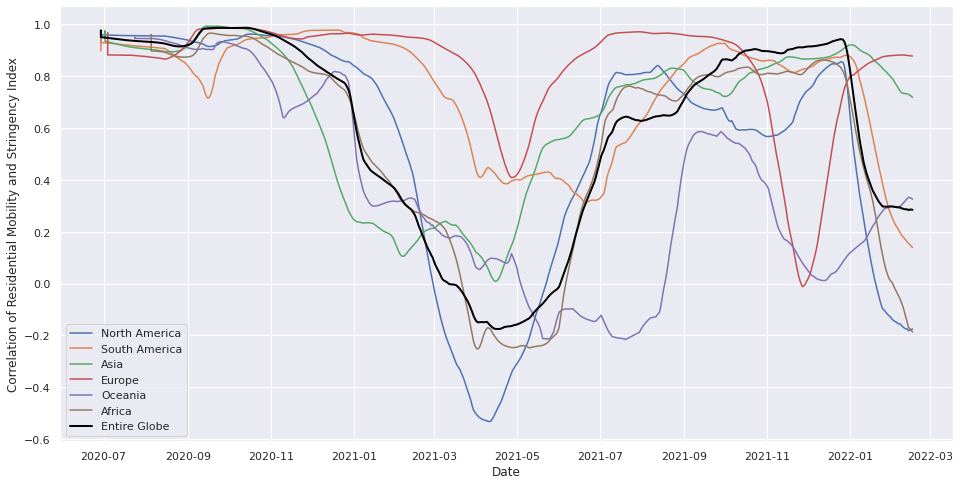

In [20]:
df_for_windows = merged_df[['date', 'continent', 'residential', 'stringency_index']]
df_for_windows['date'] = pd.to_datetime(df_for_windows['date'])

rolling_window = 180 # Averaging window of 6 months
panic_window = 90 # The first 3 months of data from Jan to March involve a lot of panic, this can throw our analysis off.

df_for_windows = df_for_windows.groupby(['date', 'continent']).agg('mean').reset_index()

for continent in df_for_windows['continent'].unique():
    residential_corr = []
    end_dates = []
    if continent not in ['0', 0]:
        print(continent) # a weird zero pops up during the aggregation... probably due to aggregations done at OWID level
        for window in df_for_windows[df_for_windows['continent']==continent].rolling(window=rolling_window):
            # if len(window) > 0:
            residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
            end_dates.append(window['date'].iloc[0] + timedelta(days=rolling_window))
        plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label=continent)
        
residential_corr = []
end_dates = []
df_for_windows = df_for_windows[['date', 'residential', 'stringency_index']].groupby(['date']).agg('mean').reset_index()
for window in df_for_windows.rolling(window=rolling_window):
    # if len(window) > 0:
    residential_corr.append(window[['residential','stringency_index']].corr()['stringency_index'][0])
    end_dates.append(list(window['date'])[0] + timedelta(days=rolling_window))
plt.plot(end_dates[panic_window:], residential_corr[panic_window:], label="Entire Globe", color="black", linewidth=2)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Correlation of Residential Mobility and Stringency Index")

Optimizing lag

In [21]:
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = merged_df['stringency_index'].corr(merged_df['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.5752429268395908


In [22]:
# Optimizing lag on a country by country basis would look like this:
greatest_abs_corr = 0
for lag in range(0,90):
    _corr = merged_df[merged_df['country'] == 'United Kingdom']['stringency_index'].corr(merged_df[merged_df['country'] == 'United Kingdom']['residential'].shift(lag))
    # print(_corr)
    if abs(_corr) > greatest_abs_corr:
        greatest_abs_corr = abs(_corr)
        print(f"{lag} days lag: {_corr}")

0 days lag: 0.8181370757644617


---

Modelling utility functions

In [23]:
def feature_engineering(df, y_feature, keep_country=False, drop_features=None, add_logs=True, add_squares=True, cross_features=False):
    if drop_features is not None:
        df = df.drop(columns=drop_features)
        
    y = df[y_feature]
    X = df.drop([y_feature], axis=1)
    X_columns = X.columns[1:]

    for col in X_columns:
        if is_numeric_dtype(X[col]):
            if add_logs:
                X[f"{col}_log"] = np.log(X[col])
            if add_squares:
                X[f"{col}_squared"] = X[col]**2

    # Cross-feature combinations
    if cross_features:
        for combo in combinations(X.columns[1:], 2):
            X[f"{combo[0]}_{combo[1]}"] = X[combo[0]] * X[combo[1]]

    X['y'] = y
    X.dropna(inplace=True)
    y = X['y']
    X = X.drop(['y'], axis=1)
    if not keep_country:
        X = X.drop(['country'], axis=1)

    return X, y

In [24]:
# https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py
def forward_regression(X, y,
                       threshold_in=0.05,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out=0.05,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

---


### Q1. Headline
* Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
* Mortality ratio (Derived from cases and deaths) - how deadly is it?
* Stringency over time  - how are governments responding?
* Mobility over time - how are people reacting?


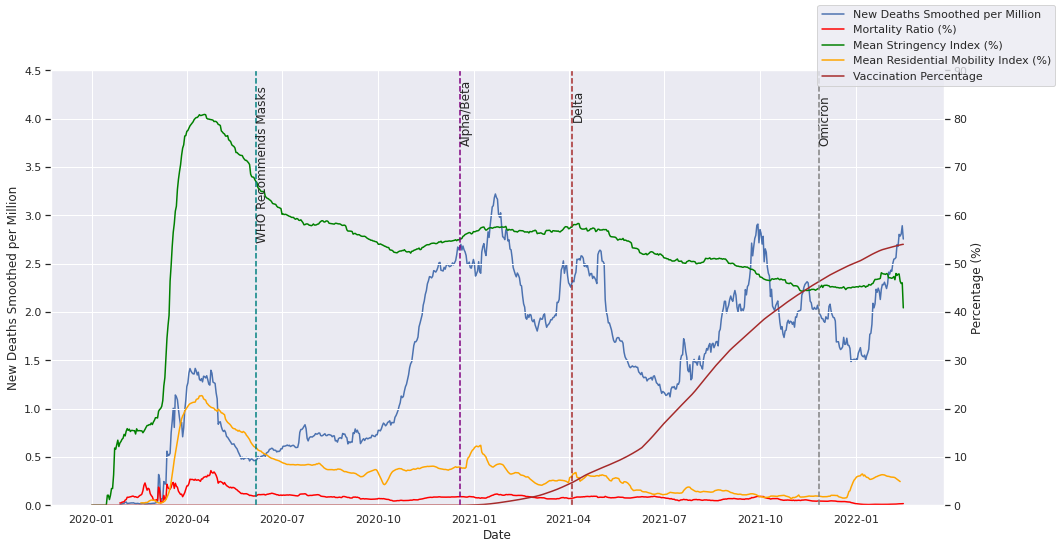

In [25]:
date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

fig, ax = plt.subplots()

# Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
ax.plot(date_mean_df['date'], date_mean_df['new_deaths_smoothed_per_million'], label='New Deaths Smoothed per Million')
ax.set_ylabel('New Deaths Smoothed per Million')
ax.set_xlabel('Date')

# Mortality ratio (Derived from cases and deaths) - how deadly is it?
ax_twin_percentages = ax.twinx()
ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
ax_twin_percentages.set_ylabel('Percentage (%)')

# Stringency over time  - how are governments responding?
ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['stringency_index'], label='Mean Stringency Index (%)', color='green')

ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

ax.set_ylim(0, 4.5)
ax_twin_percentages.set_ylim(0, 90)

# Variant lines. Dates the variants were declared variants of concern.
# Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
ax_twin_percentages.axvline(x='2020-12-18', linestyle='--', color='purple')
ax_twin_percentages.text('2020-12-18',75,'Alpha/Beta',rotation=90)
ax_twin_percentages.axvline(x='2021-04-04', linestyle='--', color='brown')
ax_twin_percentages.text('2021-04-04',80,'Delta',rotation=90)
ax_twin_percentages.axvline(x='2021-11-26', linestyle='--', color='gray')
ax_twin_percentages.text('2021-11-26',75,'Omicron',rotation=90)
ax_twin_percentages.axvline(x='2020-06-06', linestyle='--', color='teal')
ax_twin_percentages.text('2020-06-06',55,'WHO Recommends Masks',rotation=90)
fig.legend()

### Q2. Effectiveness of disaggregated measures:
a. Masks  
b. Vaccinations  
c. Lockdowns  
d. School closure  

In [26]:
face_coverings_df = pd.read_csv('data/stringency/face_coverings/face-covering-policies-covid.csv')[['Entity', 'Day', 'facial_coverings']]
face_coverings_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, face_coverings_df, on=['country', 'date'], how='left')

In [27]:
lockdowns_df = pd.read_csv('data/stringency/lockdowns/stay-at-home-covid.csv')[['Entity', 'Day', 'stay_home_requirements']]
lockdowns_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, lockdowns_df, on=['country', 'date'], how='left')

In [28]:
school_closure_df = pd.read_csv('data/stringency/school_closure/school-closures-covid.csv')[['Entity', 'Day', 'school_closures']]
school_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, school_closure_df, on=['country', 'date'], how='left')

In [29]:
workplace_closure_df = pd.read_csv('data/stringency/workplace_closure/workplace-closures-covid.csv')[['Entity', 'Day', 'workplace_closures']]
workplace_closure_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)

merged_df = pd.merge(merged_df, workplace_closure_df, on=['country', 'date'], how='left')

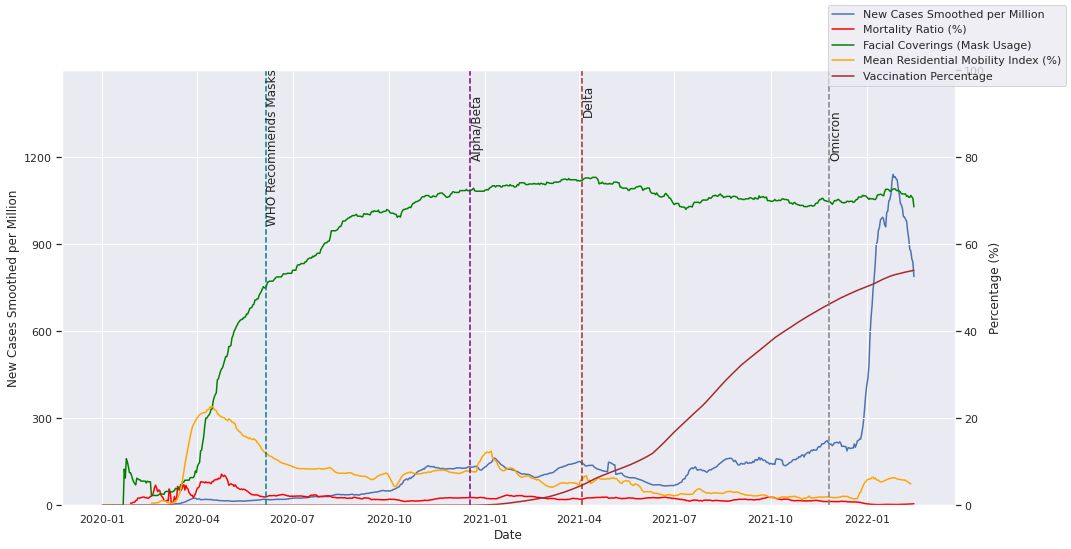

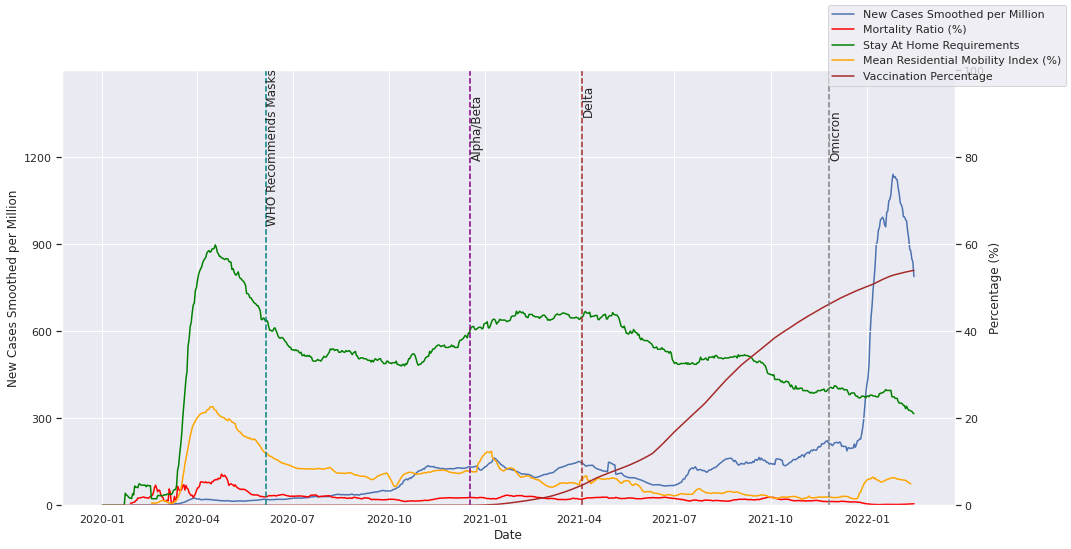

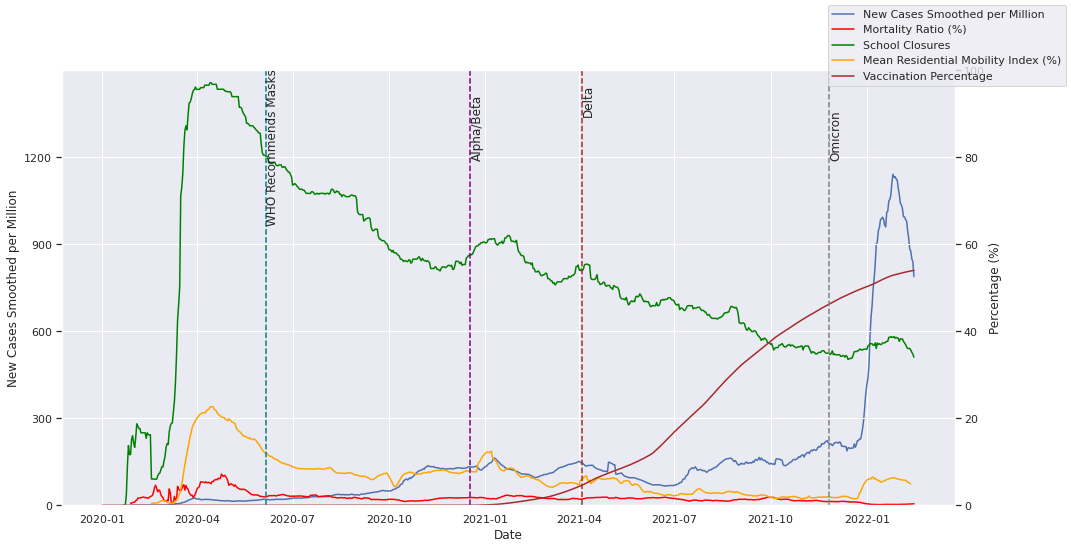

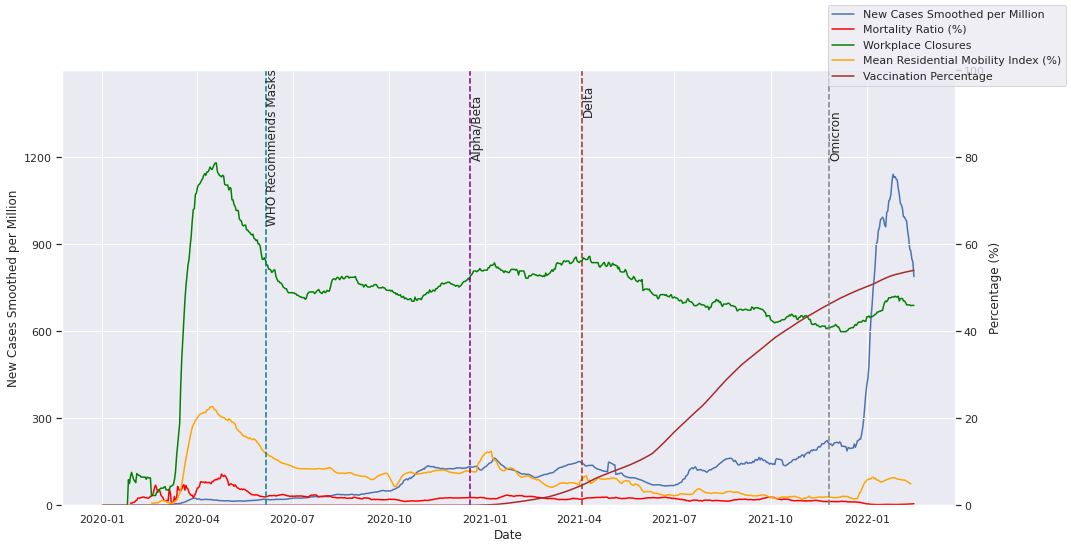

In [30]:
feature_labels = {
    'facial_coverings': 'Facial Coverings (Mask Usage)',
    'stay_home_requirements': 'Stay At Home Requirements',
    'school_closures': 'School Closures',
    'workplace_closures': 'Workplace Closures'
}
for feature in merged_df.columns[-4:]:
    merged_df[feature] = 100 * merged_df[feature]/max(merged_df[feature])
    # Sum features need to be summed in aggregation
    # Others need to be averaged in aggregation
    date_sum_df = merged_df.groupby('date').agg('sum').reset_index()
    date_mean_df = merged_df.groupby('date').agg('mean').reset_index()

    date_sum_df['date'] = pd.to_datetime(date_sum_df['date'])
    date_mean_df['date'] = pd.to_datetime(date_mean_df['date'])

    fig, ax = plt.subplots()

    # Mean of new deaths smoothed per million (show units on twin axis) - virus snapshot
    ax.plot(date_mean_df['date'], date_mean_df['new_cases_smoothed_per_million'], label='New Cases Smoothed per Million')
    ax.set_ylabel('New Cases Smoothed per Million')
    ax.set_xlabel('Date')

    # Mortality ratio (Derived from cases and deaths) - how deadly is it?
    ax_twin_percentages = ax.twinx()
    ax_twin_percentages.plot(date_sum_df['date'], 100*date_sum_df['new_deaths_smoothed_per_million']/date_sum_df['new_cases_smoothed_per_million'], label='Mortality Ratio (%)', color='red')
    ax_twin_percentages.set_ylabel('Percentage (%)')

    # Stringency over time  - how are governments responding?
    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df[feature], label=feature_labels[feature], color='green')

    ax_twin_percentages.plot(date_mean_df['date'], date_mean_df['residential'], label='Mean Residential Mobility Index (%)', color='orange')

    ax_twin_percentages.plot(date_sum_df['date'], 100*np.cumsum(date_sum_df['new_people_vaccinated_smoothed'])/date_sum_df['population'], color='brown', label='Vaccination Percentage')

    ax.set_ylim(0, 1500)
    ax.yaxis.set_ticks(np.arange(0, 1500, 300))
    ax_twin_percentages.set_ylim(0, 100)

    # Variant lines. Dates the variants were declared variants of concern.
    # Accroding to: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
    ax_twin_percentages.axvline(x='2020-12-18', linestyle='--', color='purple')
    ax_twin_percentages.text('2020-12-18',80,'Alpha/Beta',rotation=90)
    ax_twin_percentages.axvline(x='2021-04-04', linestyle='--', color='brown')
    ax_twin_percentages.text('2021-04-04',90,'Delta',rotation=90)
    ax_twin_percentages.axvline(x='2021-11-26', linestyle='--', color='gray')
    ax_twin_percentages.text('2021-11-26',80,'Omicron',rotation=90)
    ax_twin_percentages.axvline(x='2020-06-06', linestyle='--', color='teal')
    ax_twin_percentages.text('2020-06-06',65,'WHO Recommends Masks',rotation=90)

    fig.legend()
    plt.show()

In [31]:
# Policy Regressions Against Cases
policy_cases_df = merged_df[['date', 'country']+list(merged_df.columns[-4:])+['new_cases_smoothed_per_million']]

In [32]:
# Pull in stringency sub-indices
# Public event stringency
event_stringency_df = pd.read_csv('data/stringency/gatherings_and_events/public-events-covid.csv')[['Entity', 'Day', 'cancel_public_events']]
event_stringency_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(event_stringency_df, on=['country', 'date'], how='left')

# gathering restrictions
gethering_stringency_df = pd.read_csv('data/stringency/gatherings_and_events/public-gathering-rules-covid.csv')[['Entity', 'Day', 'restriction_gatherings']]
gethering_stringency_df.rename(columns={
    "Entity":"country",
    "Day":"date",
    "restriction_gatherings":"gathering_restrictions"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(gethering_stringency_df, on=['country', 'date'], how='left')

# public info campaigns
info_campaigns_df = pd.read_csv('data/stringency/information/public-campaigns-covid.csv')[['Entity', 'Day', 'public_information_campaigns']]
info_campaigns_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(info_campaigns_df, on=['country', 'date'], how='left')

# internal movement restrictions
internal_movement_df = pd.read_csv('data/stringency/movement_restrictions/internal-movement-covid.csv')[['Entity', 'Day', 'restrictions_internal_movements']]
internal_movement_df.rename(columns={
    "Entity":"country",
    "Day":"date",
    "restrictions_internal_movements":"internal_movement_restrictions"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(internal_movement_df, on=['country', 'date'], how='left')

# international travel restrictions
international_travel_df = pd.read_csv('data/stringency/movement_restrictions/international-travel-covid.csv')[['Entity', 'Day', 'international_travel_controls']]
international_travel_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(international_travel_df, on=['country', 'date'], how='left')

# public transport restrictions
public_transport_df = pd.read_csv('data/stringency/movement_restrictions/public-transport-covid.csv')[['Entity', 'Day', 'close_public_transport']]
public_transport_df.rename(columns={
    "Entity":"country",
    "Day":"date"},
    inplace=True)
policy_cases_df = policy_cases_df.merge(public_transport_df, on=['country', 'date'], how='left')

In [33]:
# get changes in cases as an alternate y variable
policy_cases_df['date'] = pd.to_datetime(policy_cases_df['date'])
policy_cases_df["cases_changes"] = policy_cases_df.groupby('country')['new_cases_smoothed_per_million'].diff()

In [34]:
policy_cases_df = policy_cases_df[policy_cases_df['date'] <= '2020-12-31']
policy_cases_df = policy_cases_df[policy_cases_df['date'] >= '2020-04-01']

<AxesSubplot:>

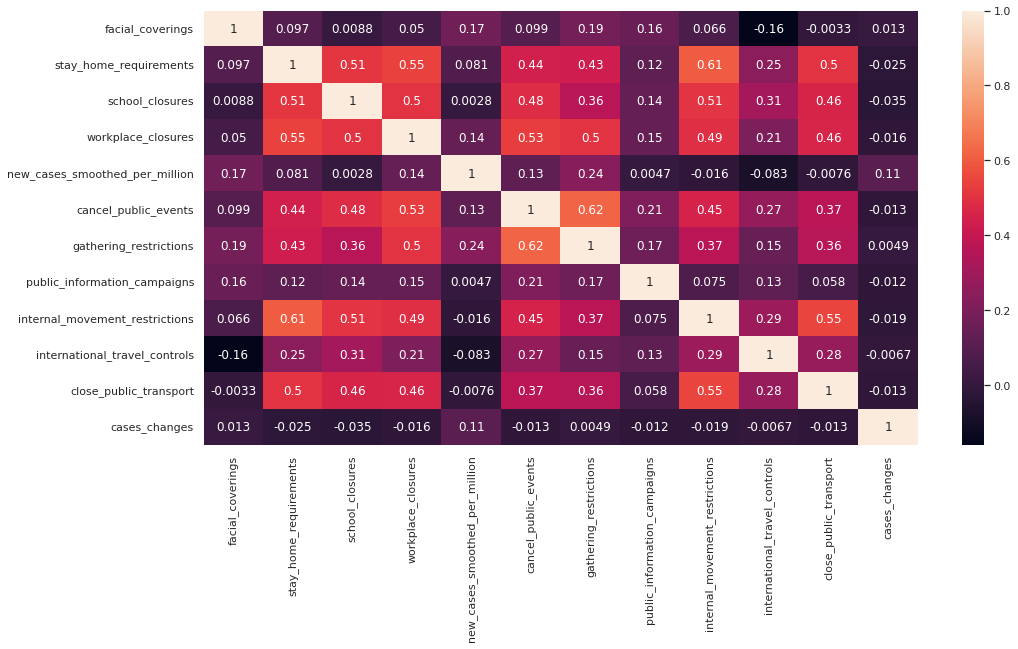

In [35]:
# correlations
sns.heatmap(policy_cases_df[policy_cases_df.columns[2:]].corr(), annot=True)

In [36]:
X, y = feature_engineering(policy_cases_df, 'new_cases_smoothed_per_million', drop_features=['cases_changes', 'date'],
                           add_logs=False, add_squares=False)

In [37]:
# check for infs
X.index[np.isinf(X).any(1)]

Int64Index([], dtype='int64')

In [38]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     581.2
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:42:38   Log-Likelihood:            -3.0311e+05
No. Observations:               48669   AIC:                         6.062e+05
Df Residuals:                   48658   BIC:                         6.063e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             40.4566      4.973      8.135      0.000      30.709      50.204
facial_coverings                   0.4953      0.018     27.563      0.000       0.460       0.531
stay_home_requirements             0.2350      0.026      9.118      0.000       0.184       0.286
school_closures                   -0.2533      0.023    -10.899      0.000      -0.299      -0.208
workplace_closures                 0.5421      0.025     21.458      0.000       0.493       0.592
cancel_public_events               4.9789      1.210      4.114      0.000       2.607       7.351
gathering_restrictions            22.1259      0.584     37.898      0.000      20.982      23.270
public_information_campaigns     -29.6015      2.577    -11.489      0.000     -34.652     -24.551
internal_movement_restrictions   -17.6442      0.874    -20.196      0.000     -19.356     -15.932
international_travel_controls     -7.6515      0.575    -13.303      0.000      -8.779      -6.524
close_public_transport           -11.2498      0.956    -11.768      0.000     -13.123      -9.376
==============================================================================
Omnibus:                    41196.681   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1179610.698
Skew:                           4.053   Prob(JB):                         0.00
Kurtosis:                      25.715   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [40]:
print(forward_included)
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

['gathering_restrictions', 'facial_coverings', 'internal_movement_restrictions', 'workplace_closures', 'international_travel_controls', 'close_public_transport', 'public_information_campaigns', 'school_closures', 'stay_home_requirements', 'cancel_public_events']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     581.2
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:42:45   Log-Likelihood:            -3.0311e+05
No. Observations:               48669   AIC:                         6.062e+05
Df Residuals:                   48658   BIC:                         6.063e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             40.4566      4.973      8.135      0.000      30.709      50.204
gathering_restrictions            22.1259      0.584     37.898      0.000      20.982      23.270
facial_coverings                   0.4953      0.018     27.563      0.000       0.460       0.531
internal_movement_restrictions   -17.6442      0.874    -20.196      0.000     -19.356     -15.932
workplace_closures                 0.5421      0.025     21.458      0.000       0.493       0.592
international_travel_controls     -7.6515      0.575    -13.303      0.000      -8.779      -6.524
close_public_transport           -11.2498      0.956    -11.768      0.000     -13.123      -9.376
public_information_campaigns     -29.6015      2.577    -11.489      0.000     -34.652     -24.551
school_closures                   -0.2533      0.023    -10.899      0.000      -0.299      -0.208
stay_home_requirements             0.2350      0.026      9.118      0.000       0.184       0.286
cancel_public_events               4.9789      1.210      4.114      0.000       2.607       7.351
==============================================================================
Omnibus:                    41196.681   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1179610.698
Skew:                           4.053   Prob(JB):                         0.00
Kurtosis:                      25.715   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
print(backward_included)
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

['facial_coverings', 'stay_home_requirements', 'school_closures', 'workplace_closures', 'cancel_public_events', 'gathering_restrictions', 'public_information_campaigns', 'internal_movement_restrictions', 'international_travel_controls', 'close_public_transport']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     581.2
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:42:46   Log-Likelihood:            -3.0311e+05
No. Observations:               48669   AIC:                         6.062e+05
Df Residuals:                   48658   BIC:                         6.063e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             40.4566      4.973      8.135      0.000      30.709      50.204
facial_coverings                   0.4953      0.018     27.563      0.000       0.460       0.531
stay_home_requirements             0.2350      0.026      9.118      0.000       0.184       0.286
school_closures                   -0.2533      0.023    -10.899      0.000      -0.299      -0.208
workplace_closures                 0.5421      0.025     21.458      0.000       0.493       0.592
cancel_public_events               4.9789      1.210      4.114      0.000       2.607       7.351
gathering_restrictions            22.1259      0.584     37.898      0.000      20.982      23.270
public_information_campaigns     -29.6015      2.577    -11.489      0.000     -34.652     -24.551
internal_movement_restrictions   -17.6442      0.874    -20.196      0.000     -19.356     -15.932
international_travel_controls     -7.6515      0.575    -13.303      0.000      -8.779      -6.524
close_public_transport           -11.2498      0.956    -11.768      0.000     -13.123      -9.376
==============================================================================
Omnibus:                    41196.681   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1179610.698
Skew:                           4.053   Prob(JB):                         0.00
Kurtosis:                      25.715   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Case changes as alternate y variable

In [42]:
X, y = feature_engineering(policy_cases_df, 'cases_changes', drop_features=['new_cases_smoothed_per_million', 'date'],
                           add_logs=False, add_squares=False)
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.25
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           1.80e-17
Time:                        10:42:46   Log-Likelihood:            -1.8550e+05
No. Observations:               48654   AIC:                         3.710e+05
Df Residuals:                   48643   BIC:                         3.711e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              1.5762      0.444      3.547      0.000       0.705       2.447
facial_coverings                   0.0047      0.002      2.928      0.003       0.002       0.008
stay_home_requirements            -0.0069      0.002     -2.987      0.003      -0.011      -0.002
school_closures                   -0.0117      0.002     -5.638      0.000      -0.016      -0.008
workplace_closures                -0.0002      0.002     -0.095      0.924      -0.005       0.004
cancel_public_events              -0.1184      0.108     -1.095      0.274      -0.330       0.094
gathering_restrictions             0.2295      0.052      4.400      0.000       0.127       0.332
public_information_campaigns      -0.5702      0.230     -2.477      0.013      -1.022      -0.119
internal_movement_restrictions    -0.0210      0.078     -0.268      0.788      -0.174       0.132
international_travel_controls      0.0998      0.051      1.942      0.052      -0.001       0.201
close_public_transport             0.0583      0.085      0.683      0.495      -0.109       0.226
==============================================================================
Omnibus:                    25171.655   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        168692677.453
Skew:                          -0.611   Prob(JB):                         0.00
Kurtosis:                     291.463   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [44]:
print(forward_included)
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

['school_closures', 'gathering_restrictions', 'stay_home_requirements', 'facial_coverings', 'public_information_campaigns']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.43
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           2.23e-19
Time:                        10:42:53   Log-Likelihood:            -1.8550e+05
No. Observations:               48654   AIC:                         3.710e+05
Df Residuals:                   48648   BIC:                         3.711e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.7246      0.438      3.939      0.000       0.866       2.583
school_closures                 -0.0114      0.002     -6.065      0.000      -0.015      -0.008
gathering_restrictions           0.2063      0.044      4.669      0.000       0.120       0.293
stay_home_requirements          -0.0066      0.002     -3.280      0.001      -0.011      -0.003
facial_coverings                 0.0040      0.002      2.564      0.010       0.001       0.007
public_information_campaigns    -0.5551      0.227     -2.449      0.014      -0.999      -0.111
==============================================================================
Omnibus:                    25253.434   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        168632078.659
Skew:                          -0.623   Prob(JB):                         0.00
Kurtosis:                     291.411   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
print(backward_included)
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

['facial_coverings', 'stay_home_requirements', 'school_closures', 'gathering_restrictions', 'public_information_campaigns']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.43
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           2.23e-19
Time:                        10:42:53   Log-Likelihood:            -1.8550e+05
No. Observations:               48654   AIC:                         3.710e+05
Df Residuals:                   48648   BIC:                         3.711e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.7246      0.438      3.939      0.000       0.866       2.583
facial_coverings                 0.0040      0.002      2.564      0.010       0.001       0.007
stay_home_requirements          -0.0066      0.002     -3.280      0.001      -0.011      -0.003
school_closures                 -0.0114      0.002     -6.065      0.000      -0.015      -0.008
gathering_restrictions           0.2063      0.044      4.669      0.000       0.120       0.293
public_information_campaigns    -0.5551      0.227     -2.449      0.014      -0.999      -0.111
==============================================================================
Omnibus:                    25253.434   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        168632078.659
Skew:                          -0.623   Prob(JB):                         0.00
Kurtosis:                     291.411   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Q3. Influences of socioeconomic & demographic factors on compliance

In [46]:
# Read in socioeconomic factors

# literacy
literacy_df = pd.read_csv('data/education/literacy-rate-by-country.csv')[[
    'Entity', 'Literacy rate (CIA Factbook (2016))'
    ]]
literacy_df.rename(columns={
    "Entity":"country",
    "Literacy rate (CIA Factbook (2016))":"literacy_rate"},
    inplace=True)

# Corruption perception
corruption_df = pd.read_csv('data/corruption/TI-corruption-perception-index.csv')[[
    'Entity', 'Corruption Perception Index - Transparency International (2018)', 'Year'
    ]]
corruption_df.rename(columns={
    "Entity":"country",
    "Corruption Perception Index - Transparency International (2018)":"corruption_index"},
    inplace=True)
corruption_df = corruption_df.groupby('country').last().reset_index().drop(columns=['Year'])

# Freedom of expression
expression_df = pd.read_csv('data/freedom_of_expression/freedom-of-expression.csv')[[
    'Entity', 'freeexpr_vdem_owid', 'Year'
    ]]
expression_df.rename(columns={
    "Entity":"country",
    "freeexpr_vdem_owid":"freedom_of_expression"},
    inplace=True)
expression_df = expression_df.groupby('country').last().reset_index().drop(columns=['Year'])

In [47]:
def get_compliance_df(start_date=None, end_date=None):
    if start_date is not None and end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
        sub_df = sub_df[sub_df['date'] >= start_date]
    elif start_date is not None:
        sub_df = merged_df[merged_df['date'] >= start_date]
    elif end_date is not None:
        sub_df = merged_df[merged_df['date'] <= end_date]
    else:
        sub_df = merged_df

    row_list = []
    tiny_population_countries = []
    for country in countries:
        # remove countries with populations less than 500,000
        if np.mean(sub_df[sub_df['country'] == country]['population']) < POPULATION_THRESHOLD:
            tiny_population_countries.append((country, np.mean(sub_df[sub_df['country'] == country]['population'])))
            continue
        row_list.append((
            country,
            np.mean(sub_df[sub_df['country'] == country]['gdp_per_capita']),
            np.mean(sub_df[sub_df['country'] == country]['life_expectancy']),
            np.mean(sub_df[sub_df['country'] == country]['human_development_index']),\
            np.mean(sub_df[sub_df['country'] == country]['median_age']),
            # np.mean(sub_df[sub_df['country'] == country]['population']),
            # np.mean(sub_df[sub_df['country'] == country]['population_density']),
            sub_df[sub_df['country'] == country]['stringency_index'].corr(sub_df[sub_df['country'] == country]['residential'])
        ))
    compliance_df = pd.DataFrame(row_list, columns=['country', 'gdp_per_capita', 'life_expectancy', 'human_development_index', 'median_age', 
                                                    # 'population', 'population_density', 
                                                    'compilance'])
    # compliance_df["area"] = compliance_df["population"] * compliance_df["population_density"]
    compliance_df = compliance_df.merge(literacy_df, on='country', how='left')
    compliance_df = compliance_df.merge(corruption_df, on='country', how='left')
    compliance_df = compliance_df.merge(expression_df, on='country', how='left')
    compliance_df = compliance_df.dropna()
    return compliance_df, tiny_population_countries
    
compliance_df, tiny_population_countries = get_compliance_df('2020-04-01', '2020-12-31')

In [48]:
tiny_population_countries

[('Andorra', 77354.0),
 ('Aruba', 107195.0),
 ('Bahamas', 396914.0),
 ('Barbados', 287708.0),
 ('Belize', 404915.0),
 ('Bermuda', 62092.0),
 ('Bhutan', 779900.0),
 ('Brunei', 441532.0),
 ('Cape Verde', 561901.0),
 ('Cyprus', 896005.0),
 ('Dominica', 72172.0),
 ('Faeroe Islands', 49053.0),
 ('Fiji', 902899.0),
 ('Greenland', 56868.0),
 ('Guyana', 790329.0),
 ('Iceland', 368792.0),
 ('Liechtenstein', 38254.0),
 ('Luxembourg', 634814.0),
 ('Macao', 658391.0),
 ('Malta', 516100.0),
 ('Monaco', 39520.0),
 ('San Marino', 34010.0),
 ('Seychelles', 98910.0),
 ('Solomon Islands', 703995.0),
 ('Suriname', 591798.0),
 ('Vanuatu', 314464.0)]

<AxesSubplot:>

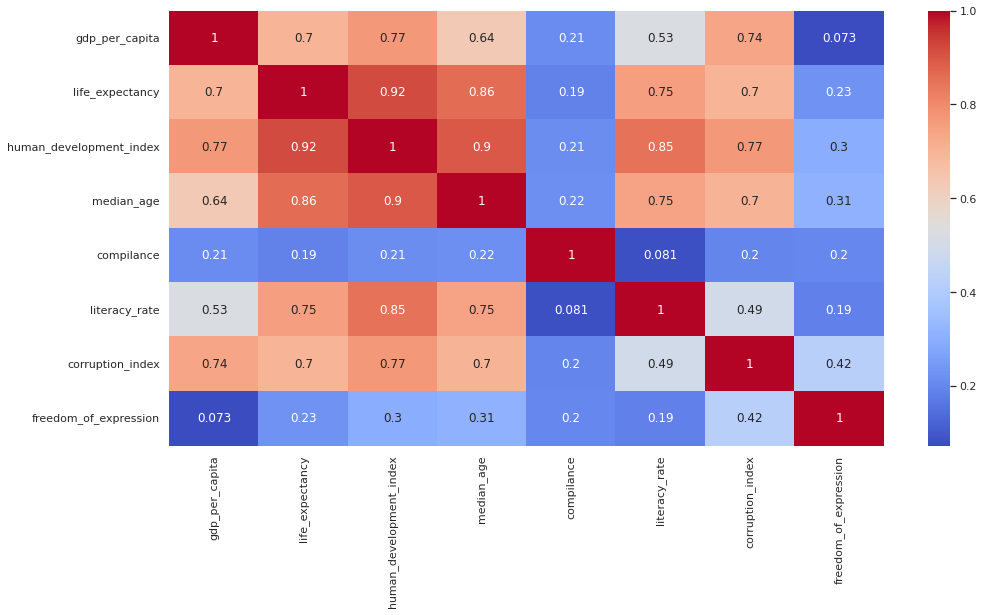

In [49]:
sns.heatmap(compliance_df.corr(), annot=True, cmap='coolwarm')

Identify outliers

In [50]:
compliance_df.columns

Index(['country', 'gdp_per_capita', 'life_expectancy',
       'human_development_index', 'median_age', 'compilance', 'literacy_rate',
       'corruption_index', 'freedom_of_expression'],
      dtype='object')

In [51]:
# Calculate logs and squares and replot graph below
X, y = feature_engineering(compliance_df, 'compilance', keep_country=True)

In [52]:
# # Investigating empty graphs
# x = X["human_development_index_log"]
# plt.scatter(x, y)
# a, b = np.polyfit(x, y, 1)

# plt.plot(x, a*x+b, color='red')
# plt.title('Correlation between {} and Compliance'.format(feature))
# plt.xlabel(feature)
# plt.ylabel('Compliance')

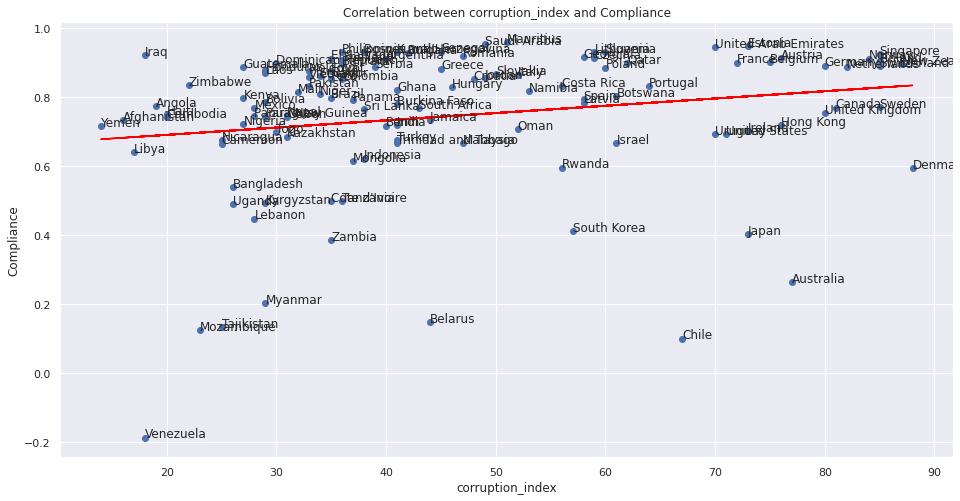

0.19826648344201606


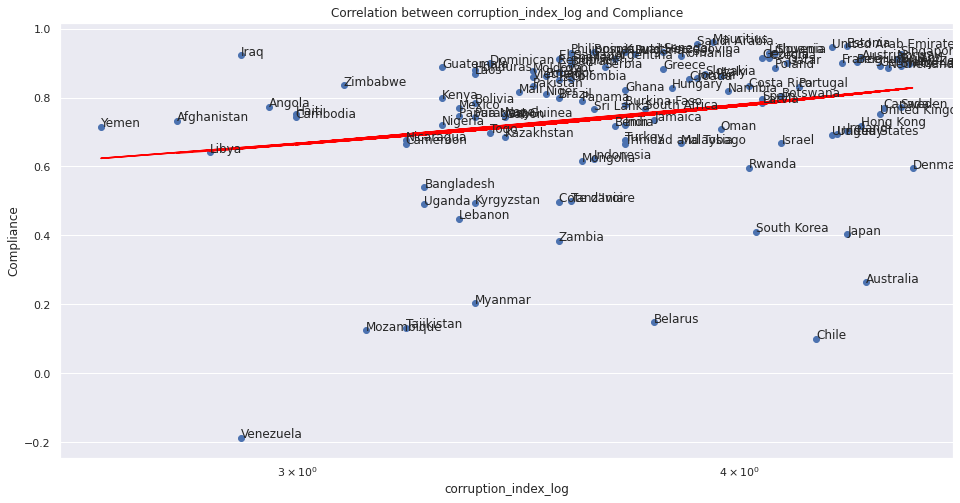

0.23274663384145555


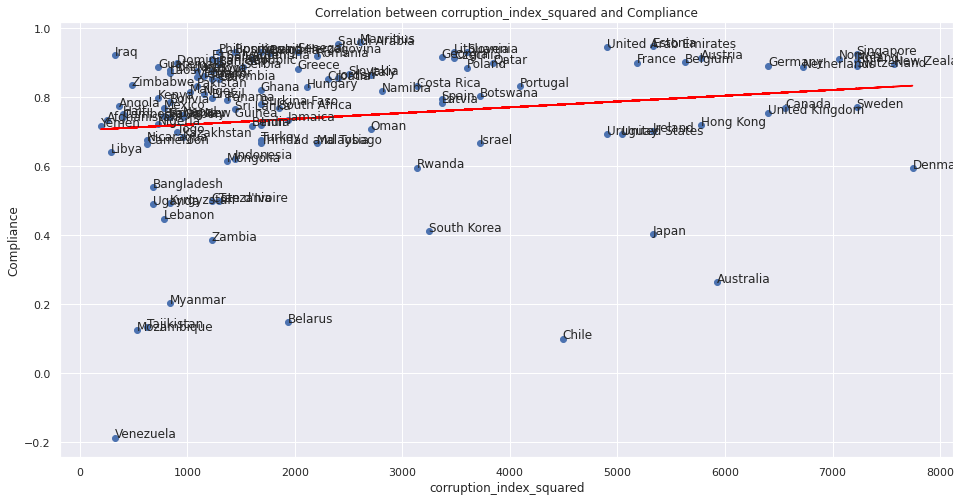

0.1654911865948479


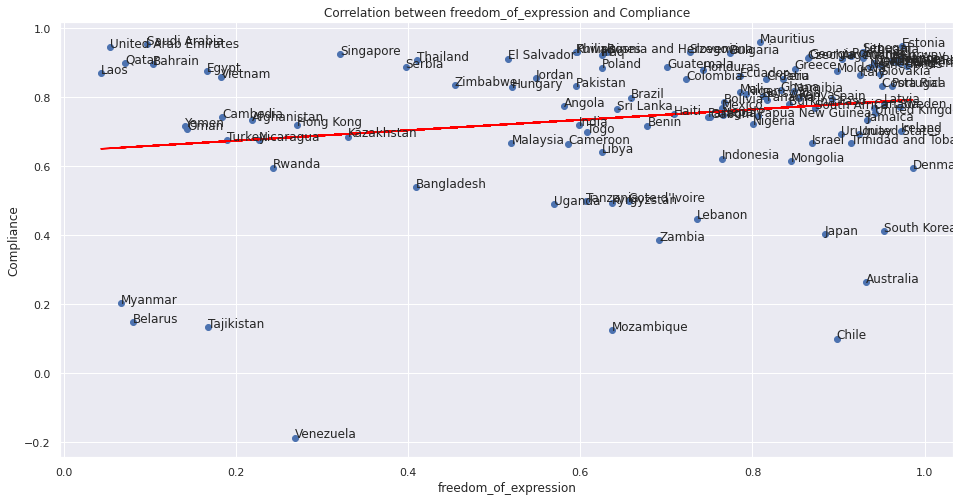

0.20090097433823434


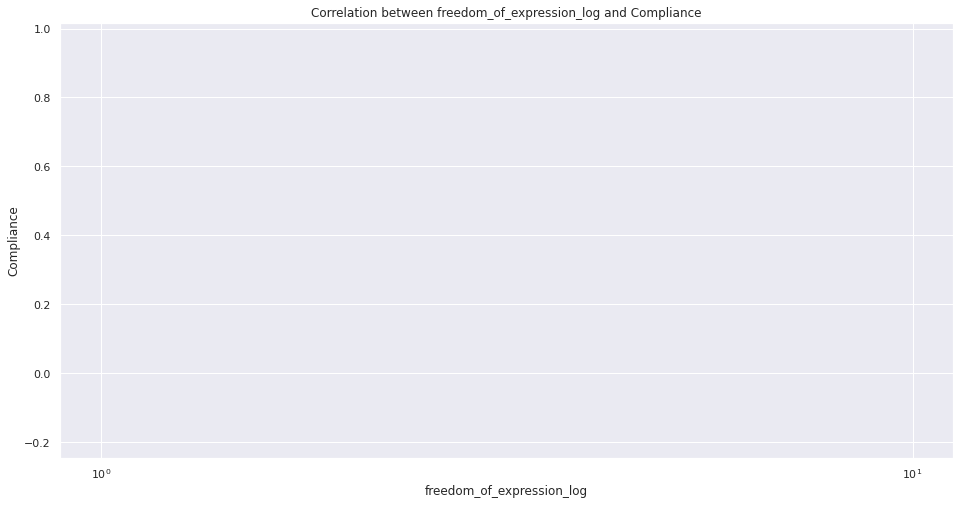

0.1712793694300591


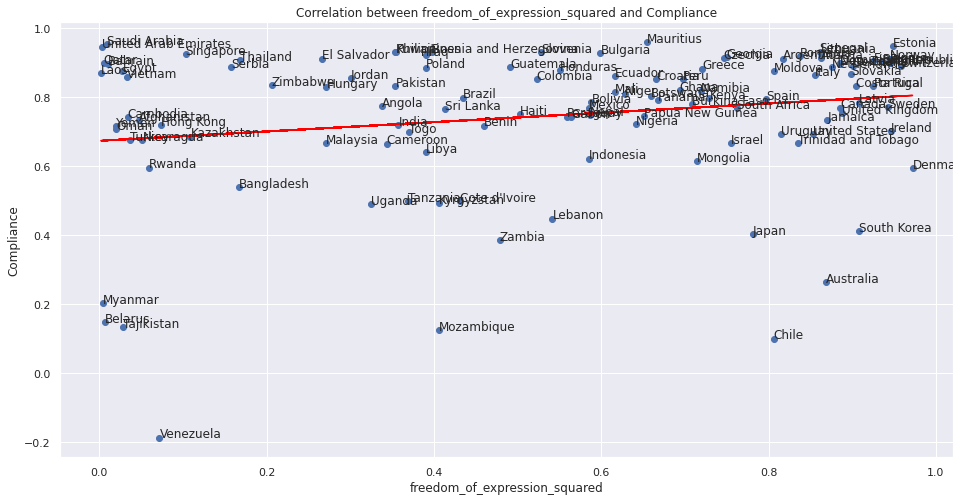

0.20274532812725946


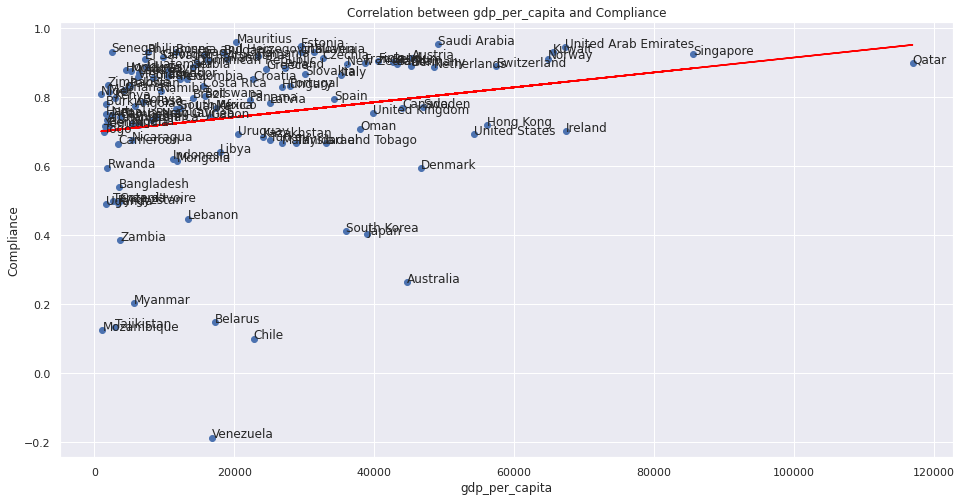

0.21114257631185823


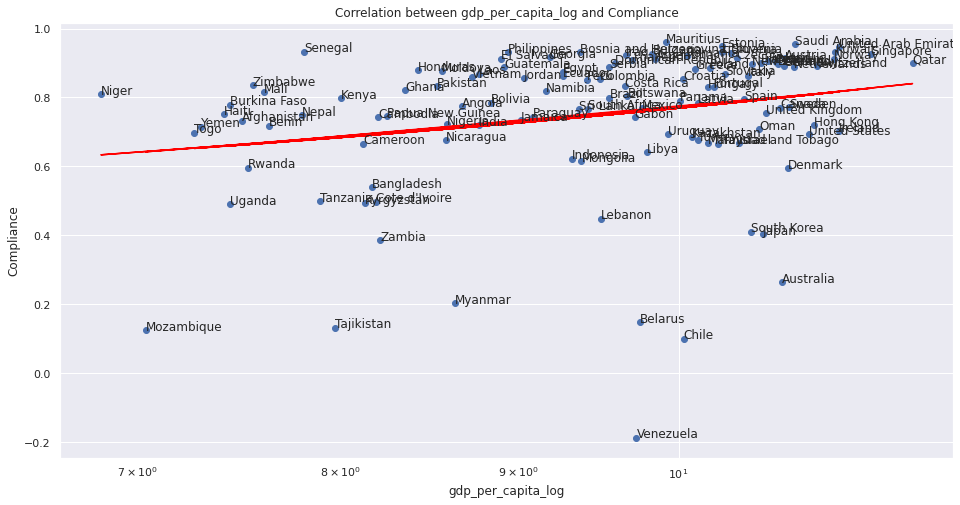

0.23313050628552479


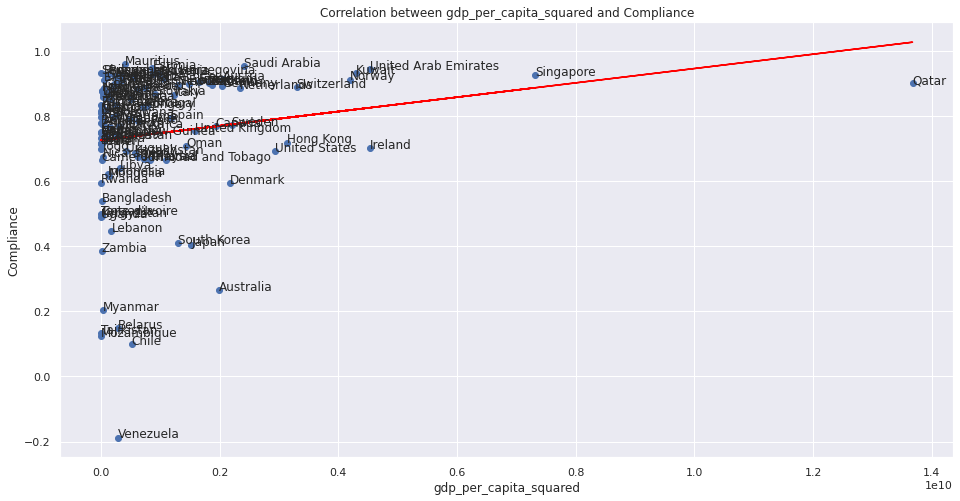

0.1781087814955622


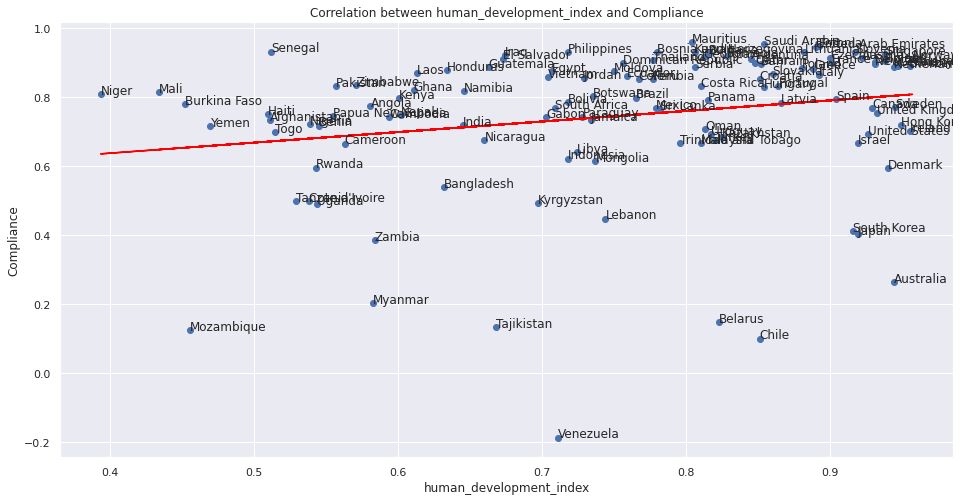

0.2149688260333538


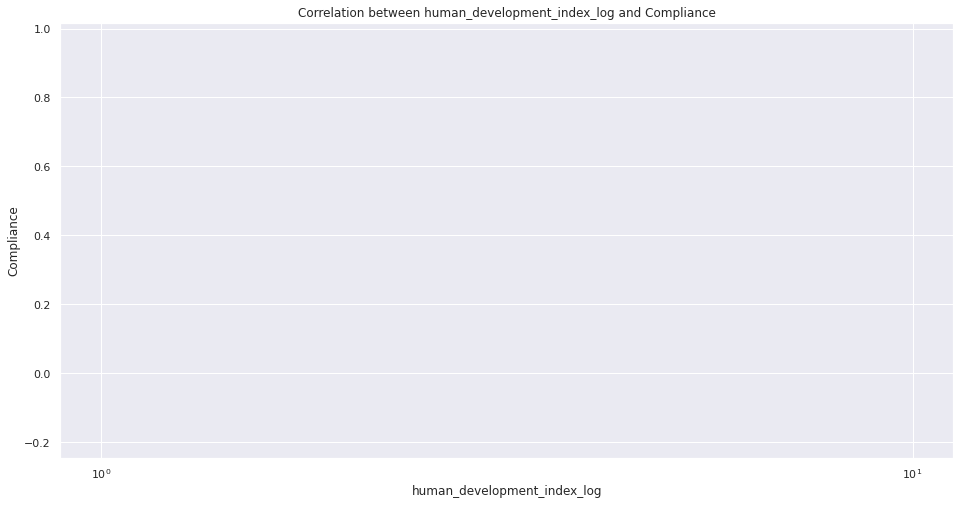

0.21266741006110798


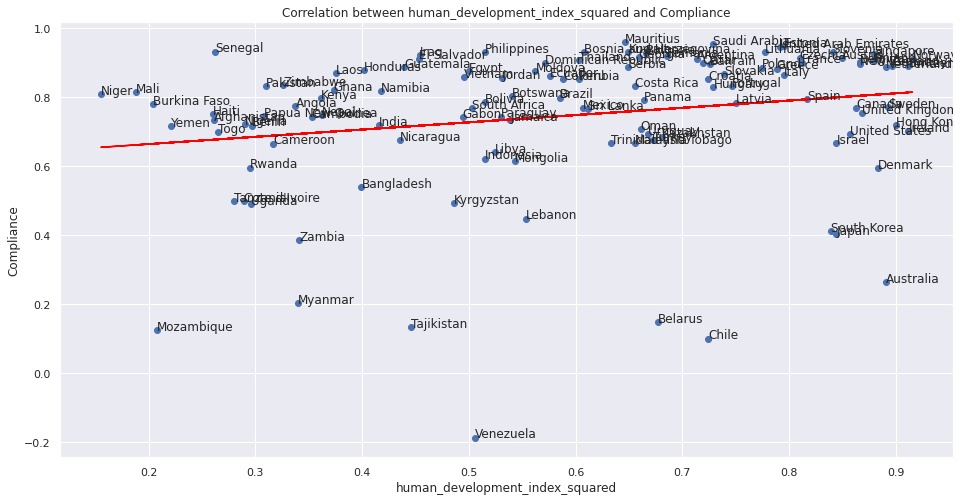

0.21316763679135442


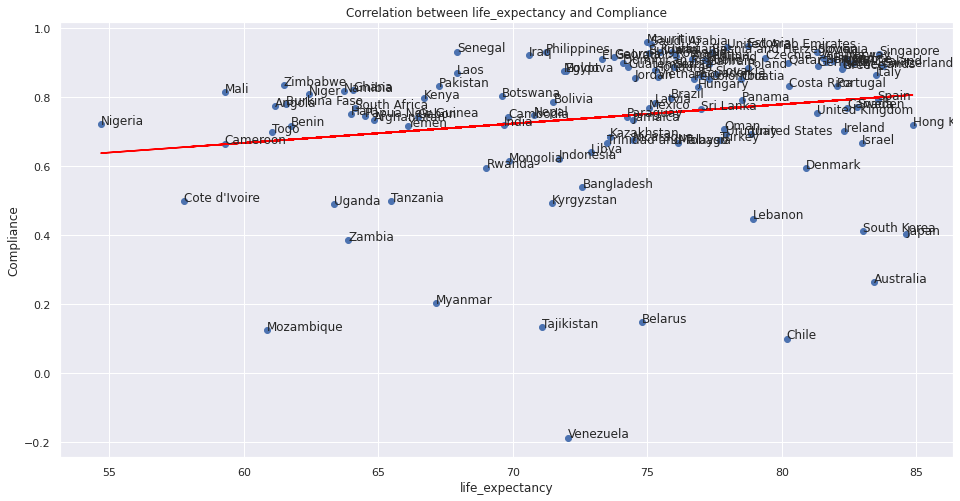

0.19061315187136435


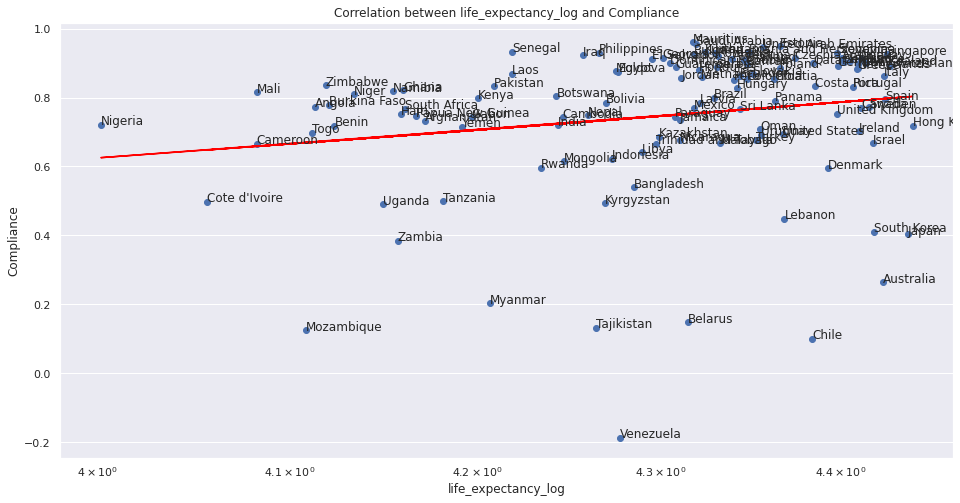

0.19314904765531787


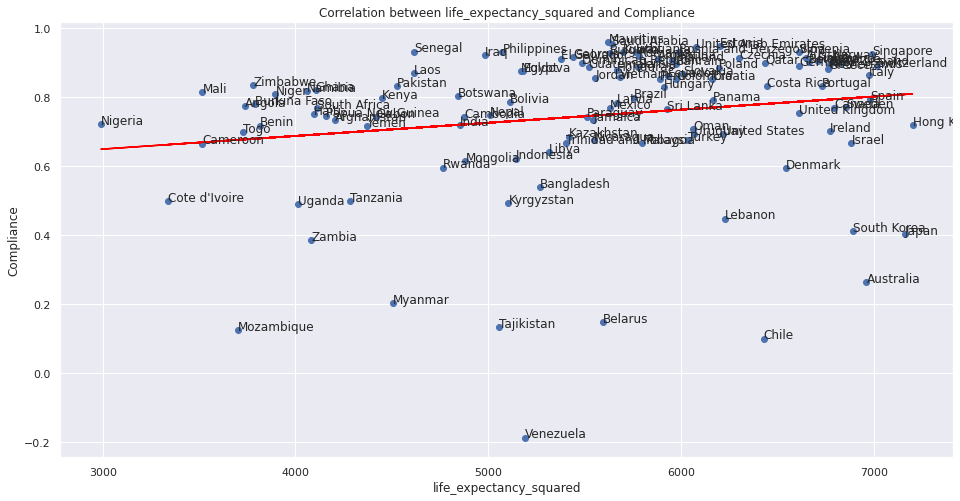

0.18705155770435694


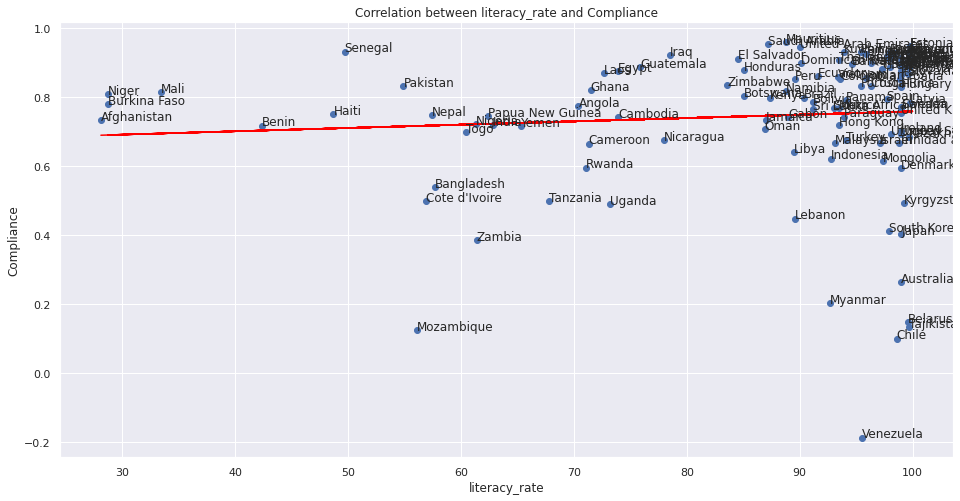

0.08144242625646718


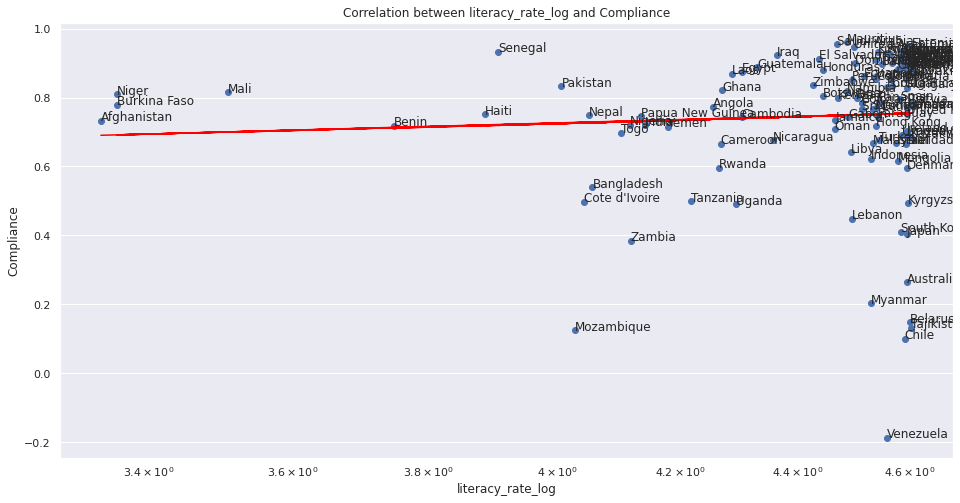

0.065612710372312


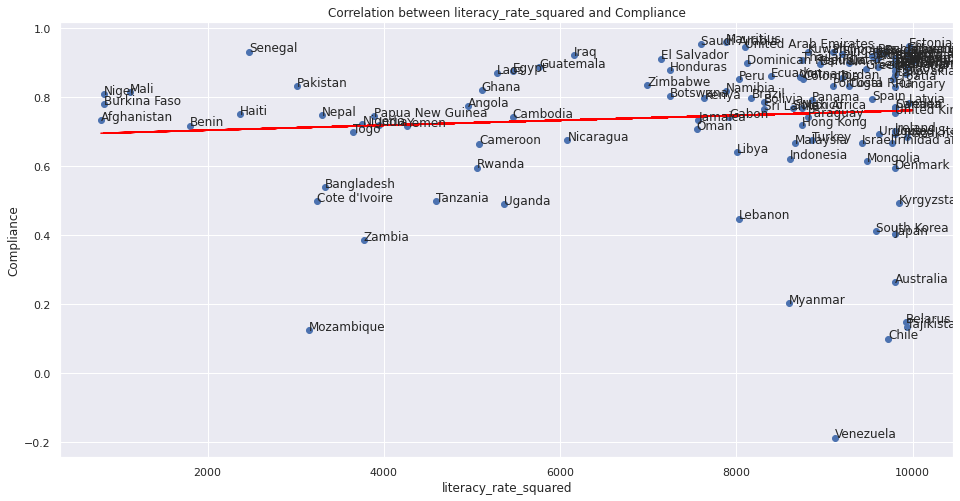

0.08847657116204001


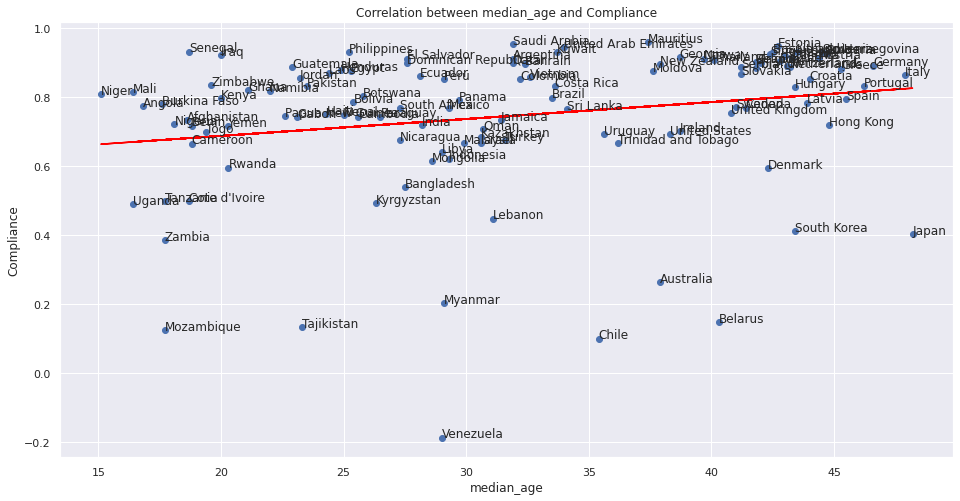

0.21840715839769362


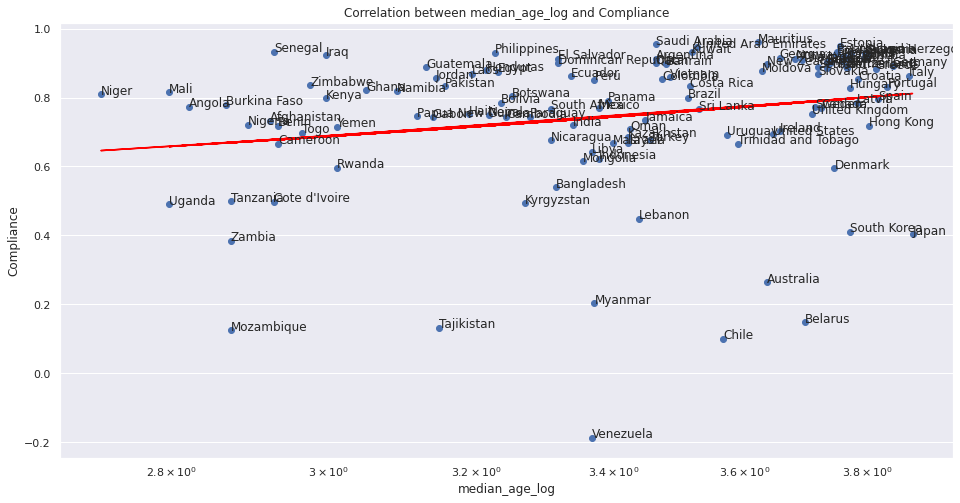

0.2133354417980452


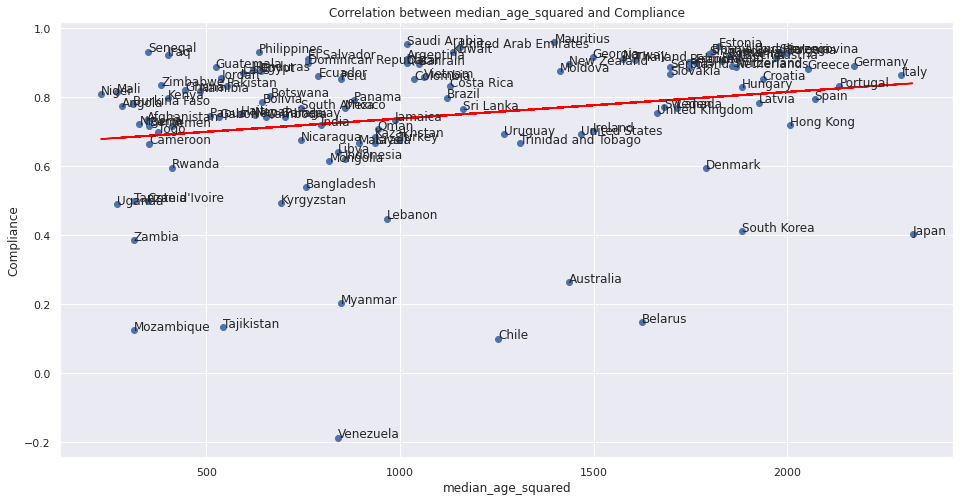

0.21990456128435207


In [53]:
for feature in sorted(X.columns):
    if feature == 'country': # Skip the country column
        continue
    x = X[feature]
    plt.scatter(x, y)
    a, b = np.polyfit(x, y, 1)
    
    plt.plot(x, a*x+b, color='red')
    plt.title('Correlation between {} and Compliance'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('Compliance')

    for i, txt in zip(X.index, X['country']):
        plt.annotate(txt, (x[i], y[i]), clip_on=True)

    if feature.endswith('log'):
        plt.xscale('log')
    else:
        plt.xscale('linear')
        
    plt.show()
    print(x.corr(y))

##### Modelling:

In [54]:
X, y = feature_engineering(compliance_df, 'compilance')

In [55]:
feature_importance_df = pd.DataFrame(columns=['feature', 'corr', 'corr_squared'])
for feature in X.columns[1:]:
    feature_importance_df = feature_importance_df.append(
        pd.Series((feature, X[feature].corr(y), X[feature].corr(y)**2), index = ['feature', 'corr', 'corr_squared']), 
           ignore_index=True)
feature_importance_df.sort_values(by='corr_squared', ascending=False, inplace=True)
feature_importance_df.head(15)

feature      corr  corr_squared
6                gdp_per_capita_log  0.233131      0.054350
16             corruption_index_log  0.232747      0.054171
13               median_age_squared  0.219905      0.048358
2                        median_age  0.218407      0.047702
1           human_development_index  0.214969      0.046212
12                   median_age_log  0.213335      0.045512
11  human_development_index_squared  0.213168      0.045440
10      human_development_index_log  0.212667      0.045227
19    freedom_of_expression_squared  0.202745      0.041106
5             freedom_of_expression  0.200901      0.040361
4                  corruption_index  0.198266      0.039310
8               life_expectancy_log  0.193149      0.037307
0                   life_expectancy  0.190613      0.036333
9           life_expectancy_squared  0.187052      0.034988
7            gdp_per_capita_squared  0.178109      0.031723

In [56]:
def insample_rsquared(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    lr_preds = lr.predict(X)
    return r2_score(y, lr_preds)

In [57]:
insample_rsquared(X, y)

0.35488227045737575

In [58]:
sm.OLS(y, sm.add_constant(X)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     2.489
Date:                Wed, 20 Apr 2022   Prob (F-statistic):            0.00145
Time:                        10:44:05   Log-Likelihood:                 43.210
No. Observations:                 117   AIC:                            -42.42
Df Residuals:                      95   BIC:                             18.35
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             332.3544    150.197      2.213      0.029      34.175     630.534
gdp_per_capita                  -6.037e-06   9.49e-06     -0.636      0.526   -2.49e-05    1.28e-05
life_expectancy                     3.7018      1.535      2.412      0.018       0.655       6.749
human_development_index             2.4649     26.879      0.092      0.927     -50.896      55.826
median_age                         -0.3797      0.211     -1.796      0.076      -0.800       0.040
literacy_rate                       0.2881      0.083      3.490      0.001       0.124       0.452
corruption_index                   -0.0285      0.031     -0.929      0.355      -0.089       0.032
freedom_of_expression               0.6898      1.174      0.588      0.558      -1.640       3.020
gdp_per_capita_log                 -0.0153      0.105     -0.145      0.885      -0.224       0.193
gdp_per_capita_squared           8.423e-11    6.4e-11      1.315      0.192   -4.29e-11    2.11e-10
life_expectancy_log              -121.4743     52.990     -2.292      0.024    -226.672     -16.277
life_expectancy_squared            -0.0140      0.006     -2.538      0.013      -0.025      -0.003
human_development_index_log        -1.6874      8.446     -0.200      0.842     -18.455      15.080
human_development_index_squared     1.1734     10.311      0.114      0.910     -19.296      21.643
median_age_log                      5.1952      3.083      1.685      0.095      -0.926      11.316
median_age_squared                  0.0034      0.002      1.953      0.054   -5.56e-05       0.007
literacy_rate_log                  -8.0066      2.355     -3.400      0.001     -12.681      -3.332
literacy_rate_squared              -0.0012      0.000     -3.678      0.000      -0.002      -0.001
corruption_index_log                0.6965      0.627      1.112      0.269      -0.547       1.940
corruption_index_squared            0.0001      0.000      0.777      0.439      -0.000       0.000
freedom_of_expression_log          -0.0361      0.190     -0.190      0.850      -0.413       0.341
freedom_of_expression_squared      -0.3466      0.691     -0.502      0.617      -1.719       1.026
==============================================================================
Omnibus:                       20.904   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.273
Skew:                          -0.954   Prob(JB):                     1.20e-06
Kurtosis:                       4.398   Cond. No.                     1.77e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The c

---

In [59]:
forward_included = forward_regression(X, y)
backward_included = backward_regression(X, y)

In [60]:
forward_included

['gdp_per_capita_log']

In [61]:
insample_rsquared(X[forward_included], y)

0.05434983296094498

In [62]:
sm.OLS(y, sm.add_constant(X[forward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     6.609
Date:                Wed, 20 Apr 2022   Prob (F-statistic):             0.0114
Time:                        10:44:07   Log-Likelihood:                 20.838
No. Observations:                 117   AIC:                            -37.68
Df Residuals:                     115   BIC:                            -32.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3415      0.158      2.157      0.033       0.028       0.655
gdp_per_capita_log     0.0427      0.017      2.571      0.011       0.010       0.076
==============================================================================
Omnibus:                       63.508   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.264
Skew:                          -2.074   Prob(JB):                     5.38e-44
Kurtosis:                       7.865   Cond. No.                         80.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

In [63]:
backward_included

['life_expectancy',
 'literacy_rate',
 'freedom_of_expression',
 'gdp_per_capita_squared',
 'life_expectancy_log',
 'life_expectancy_squared',
 'median_age_squared',
 'literacy_rate_log',
 'literacy_rate_squared']

In [64]:
insample_rsquared(X[backward_included], y)

0.285764024384364

In [65]:
sm.OLS(y, sm.add_constant(X[backward_included])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     4.757
Date:                Wed, 20 Apr 2022   Prob (F-statistic):           2.48e-05
Time:                        10:44:09   Log-Likelihood:                 37.256
No. Observations:                 117   AIC:                            -54.51
Df Residuals:                     107   BIC:                            -26.89
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     282.2562    114.125      2.473      0.015      56.017     508.495
life_expectancy             2.9755      1.182      2.518      0.013       0.633       5.318
literacy_rate               0.2446      0.072      3.413      0.001       0.103       0.387
freedom_of_expression       0.2887      0.075      3.874      0.000       0.141       0.436
gdp_per_capita_squared   4.162e-11   1.29e-11      3.239      0.002    1.61e-11    6.71e-11
life_expectancy_log       -98.5966     41.432     -2.380      0.019    -180.731     -16.463
life_expectancy_squared    -0.0111      0.004     -2.652      0.009      -0.019      -0.003
median_age_squared          0.0002   6.38e-05      3.357      0.001    8.78e-05       0.000
literacy_rate_log          -6.7738      2.037     -3.325      0.001     -10.813      -2.735
literacy_rate_squared      -0.0010      0.000     -3.571      0.001      -0.002      -0.000
==============================================================================
Omnibus:                       38.806   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.643
Skew:                          -1.381   Prob(JB):                     8.37e-18
Kurtosis:                       5.916   Cond. No.                     1.35e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

In [66]:
compliance_df.sort_values('literacy_rate', ascending=False)

country  gdp_per_capita  life_expectancy  human_development_index  \
102        Norway       64800.057            82.40                    0.957   
45        Finland       40585.721            81.91                    0.938   
77         Latvia       25063.846            75.29                    0.866   
42        Estonia       29481.252            78.74                    0.892   
124      Slovenia       31400.840            81.32                    0.917   
..            ...             ...              ...                      ...   
12          Benin        2064.236            61.77                    0.545   
86           Mali        2014.306            59.31                    0.434   
100         Niger         926.000            62.42                    0.394   
18   Burkina Faso        1703.102            61.58                    0.452   
0     Afghanistan        1803.987            64.83                    0.511   

     median_age  compilance  literacy_rate  corruption_index  \
102        39.7    0.912247          100.0              84.0   
45         42.8    0.905450          100.0              85.0   
77         43.9    0.784700           99.8              58.0   
42         42.7    0.948182           99.8              73.0   
124        44.5    0.930354           99.7              60.0   
..          ...         ...            ...               ...   
12         18.8    0.717813           42.4              40.0   
86         16.4    0.815316           33.4              32.0   
100        15.1    0.809194           28.7              34.0   
18         17.6    0.779123           28.7              41.0   
0          18.6    0.733011           28.1              16.0   

     freedom_of_expression  
102                  0.972  
45                   0.962  
77                   0.953  
42                   0.974  
124                  0.727  
..                     ...  
12                   0.678  
86                   0.785  
100                  0.793  
18                   0.842  
0                    0.218  

[117 rows x 9 columns]

---
**Note:**  
Taiwan has no GDP per capita  
Aruba, Belize and Fiji have no perceived corruption index